In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects
import numpy as np
from dataclasses import dataclass
import pandas as pd
import vice
from scipy.interpolate import interp1d
from scipy.integrate import quad
import random

In [3]:
import surp

modified solar abundances via mag++22


In [4]:
from surp.analysis.vice_model import vice_model
from surp.analysis import apogee_analysis as aah
import seaborn as sns
import arya
import surp

from statsmodels.distributions import ECDF


In [5]:
fiducial = vice_model("../out/C11_f0.2.json")

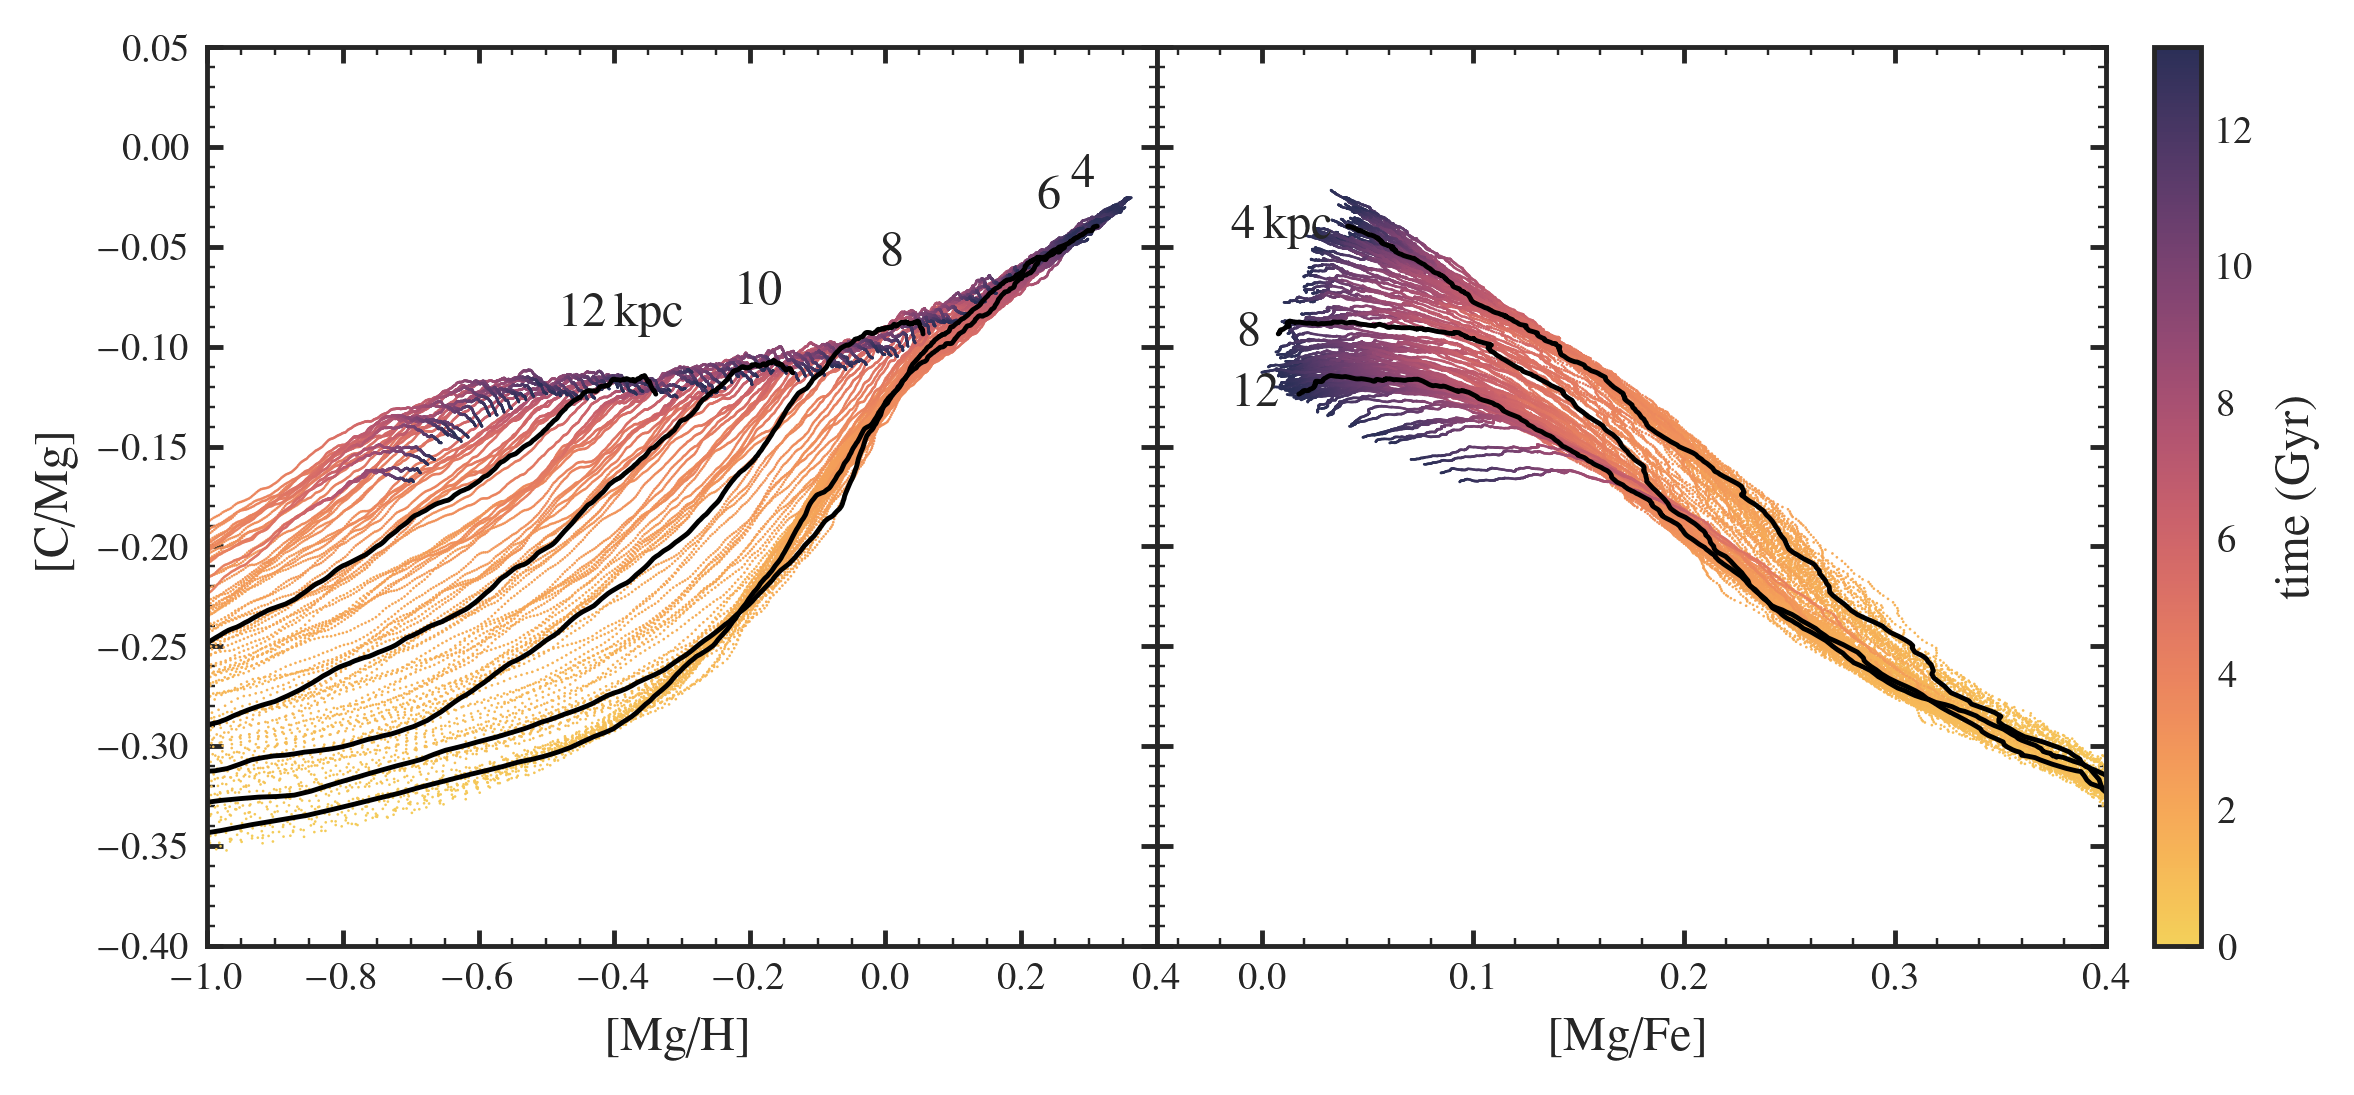

In [9]:
fig, axs = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace": 0}, figsize=(7, 10/3), dpi=350)

plt.sca(axs[0])
h = fiducial.history

coords = []

for R in [4, 6, 8, 10, 12]:
    df = h[np.isclose(h.R, R - 0.05)]
    plt.plot(df["[o/h]"], df["[c/o]"], color="k")
    coords.append((
            df["[o/h]"][-1], 
            df["[c/o]"][-1]
        ))


texts = [
    "4",
    "6",
    "8",
    "10",
    r"12\,kpc"
]

for i in range(len(coords)):
    if i >= 2:
        offset = (-6, 12)
    else:
        offset = (-3, 6)
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="center", va="bottom",  
                        xycoords='data', textcoords='offset points', xytext=offset)

sns.scatterplot(h[(h.R > 2) & (h.R < 15.5)], x="[o/h]", y="[c/o]", hue="time", s=0.3, alpha=1, legend=False, edgecolor="none", palette="arya_r", rasterized=True)
plt.xlim(-1, 0.4)
plt.ylim(-0.4, 0.05)


plt.xlabel("[Mg/H]")
plt.ylabel("[C/Mg]")

plt.sca(axs[1])



filt = fiducial.history["[o/h]"] > -0.15
filt &= fiducial.history["[o/h]"] < -0.05
h = fiducial.history

cax = axs[1].inset_axes([1.05, 0., 0.05, 1])

cb = arya.Colorbar(clim=(0, 13.2), label=r"time (Gyr)", cmap="arya_r", cax=cax)


label_Rs = [4,8,12]
coords = []

for R in np.sort(h.R.unique()[19:155]):
    dfa = h[h.R == R]
    s = 1# 0*(0.05 - np.abs(dfa["[o/h]"] + 0.10))
    plt.scatter(dfa["[o/fe]"], dfa["[c/o]"], c=cb(dfa.time), s=0.3, ec="none", rasterized=True, zorder=1)
    if any(np.isclose(R+0.05, label_Rs)):
        coords.append((
            dfa["[o/fe]"][-1], 
            dfa["[c/o]"][-1]
        ))

        plt.plot(dfa["[o/fe]"], dfa["[c/o]"], color="k", zorder=2, lw=1)
    

texts = [
    "4\\,kpc",
   #"6",
    "8",
    #"10",
    r"12"
]

for i in range(len(coords)):
    text = plt.annotate(texts[i], xy=coords[i],  zorder=20, ha="right",  va="center",
                        xycoords='data', textcoords='offset points', xytext=(-3, 0))
#     text.set_path_effects([mpl.patheffects.Stroke(linewidth=5, foreground='w'),
#                    mpl.patheffects.Normal()])
    
plt.xlim(-0.05, 0.4)
# plt.ylim(-0.35, 0.05)
plt.xlabel("[Mg/Fe]")



plt.savefig("figures/all_the_tracks.pdf")

# F AGB
Here, I want to make plots of the AGB Fraction across the galaxy.

In [7]:
def y_cc(Z):
    return surp.yields.C_CC_model(zeta=0.09, y0=0.004)(Z)

In [8]:
h = fiducial.history
m_star = h["sfr"]*1e9 # Msun/yr (default)
denom = 1 + h["eta_0"] - h["r_eff"]
Zc = h["z(c)"]
Mc = h["mass(c)"] # Msun
dt = h.time.unique()[1] # Gyr

smooth = 10
Mc_dot = np.concatenate([np.zeros(smooth), 
                         Mc[smooth:] - np.array(Mc[:-smooth]),
                        ]
                       )/(smooth*dt)
Z = h["z"]

yc_cc = y_cc(Z)
y_c = (Mc_dot + denom*Zc*m_star)/m_star
y_c_agb = y_c - yc_cc
f_agb = np.array(y_c_agb/y_c)

X = np.reshape(f_agb, (200, -1))

In [10]:
surp.yields.ZETA_0/vice.yields.ccsne.settings["mg"] * surp.yields.Z_SUN

0.9336016096579476

In [9]:
max(f_agb[f_agb < 0.5])

0.14888180221553168

(-1.0, 1.0)

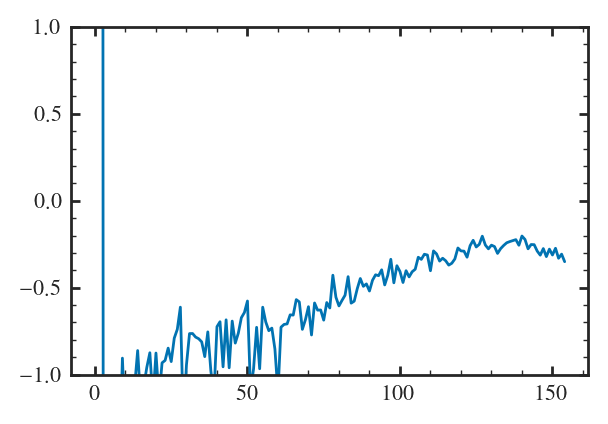

In [10]:
plt.plot(np.transpose(X)[-1,:])
plt.ylim(-1, 1)

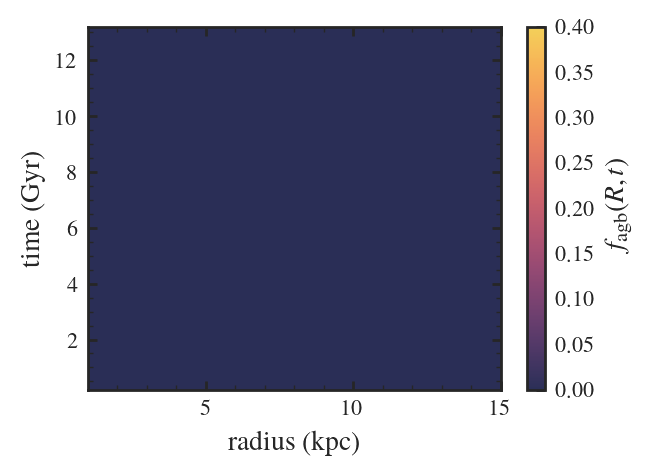

In [11]:
plt.figure(figsize=(10/3, 10/3/np.sqrt(2)))
plt.imshow(np.transpose(X)[::-1], clim=(0, 0.4), extent=(0, 20, 0, 13.2), aspect="auto")
plt.xlim(1, 15)
plt.ylim(smooth*dt)

plt.colorbar(label=r"$f_{\rm agb}(R, t)$")
plt.xlabel("radius (kpc)")
plt.ylabel("time (Gyr)")

plt.savefig("figures/f_agb_rt.pdf")

Text(0, 0.5, '[N/Mg]')

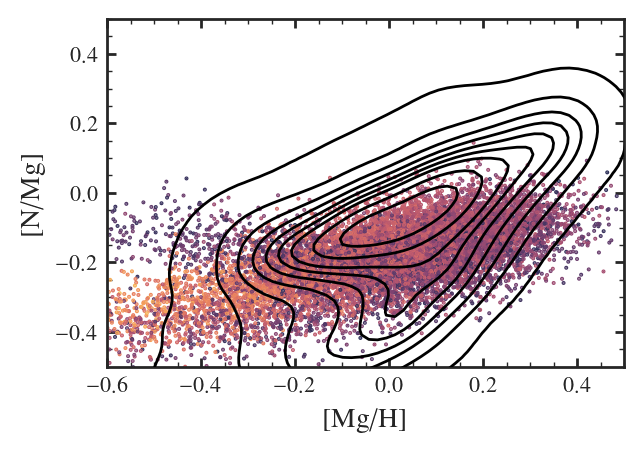

In [18]:
s = fiducial.stars
N = len(s)
dx = 0.09
dy = 0.05
aah.plot_contour("[mg/h]", "[n/mg]", zorder=3, exclude_high_alpha=False)

plt.scatter(s["[mg/h]"] + np.random.normal(0, dx, N), s["[n/mg]"] + np.random.normal(0, dy, N), 
             c = s["r_origin"], s=0.2, zorder=2)
plt.xlim(-0.6, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel("[Mg/H]")
plt.ylabel("[N/Mg]")


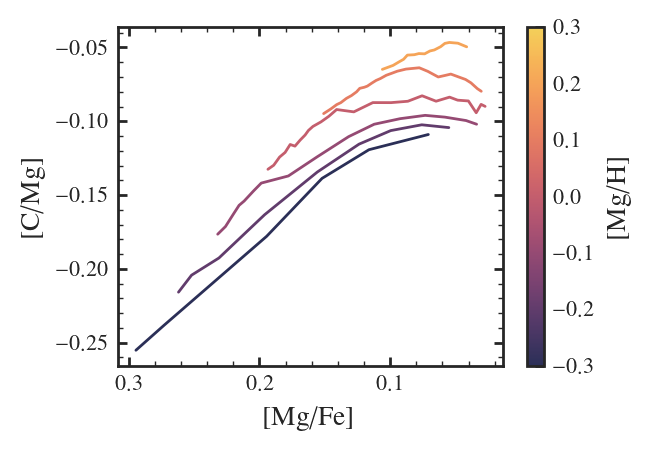

In [30]:
plt.figure(figsize=(10/3, 10/3/2**0.5))

cb = arya.Colorbar(clim=(-0.3, 0.3), label="[Mg/H]")

s = fiducial.stars
for MH in (-0.3, -0.2,-0.1,0, 0.1, 0.2,0.3):
    mh0 = MH - 0.05
    mh1 = MH + 0.05
    filt = s["[o/h]"] > mh0
    filt &= s["[o/h]"] < mh1
    df = s[filt]
    
    arya.medianplot(df, x="[o/fe]", y="[c/o]", binsize=100, color=cb(MH), aes="line", errorbar=None)

plt.gca().invert_xaxis()

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")

plt.tight_layout()
plt.savefig("figures/fiducial_caafe_binned.pdf")